In [ ]:
!pip install model_card_toolkit

In [99]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

In [5]:
from tensorflow import keras
model = keras.models.load_model('data/saved_model/20210221-12111613909466-tf_ep-10_img-87867_acc_0.973-model_cnn_1.h5')

In [22]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 50CF-3B3C

 Directory of C:\Users\27625\Documents\dev\Untitled Folder

2021/02/22  10:17    <DIR>          .
2021/02/22  10:17    <DIR>          ..
2021/02/22  10:12    <DIR>          .ipynb_checkpoints
2021/02/22  10:12         3ÿ167ÿ253 crop_disease_classification.ipynb
2021/02/22  10:09    <DIR>          data
2021/02/22  10:17            15ÿ590 Untitled.ipynb
               2 File(s)      3ÿ182ÿ843 bytes
               4 Dir(s)  41ÿ385ÿ750ÿ528 bytes free


In [23]:
# Get Path to Train and Valid folders
train_path = 'D:\\downloads\\dev\\cookie\\dev_mlflow\\data\\crop\\train'
valid_path = 'D:\\downloads\\dev\\cookie\\dev_mlflow\\data\\crop\\valid'

# Get list of all subfolders for each Subset
train_dir = os.listdir(train_path)
valid_dir = os.listdir(valid_path)
# Check length of subfolders
len(train_dir), len(valid_dir)

(38, 38)

In [8]:
import os
import pandas as pd

test_path = 'data/test/test'

test_imgs = [os.path.join(test_path, img) for img in os.listdir(test_path)]
df_test = pd.DataFrame(test_imgs, columns=['Path'])

df_test.head()

,Path
0,data/test/test\AppleCedarRust1.JPG
1,data/test/test\AppleCedarRust2.JPG
2,data/test/test\AppleCedarRust3.JPG
3,data/test/test\AppleCedarRust4.JPG
4,data/test/test\AppleScab1.JPG


In [12]:
# Creation of constants
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
OUTPUT_SHAPE = 38
NUM_EPOCHS = 10

In [15]:
# Decode and load image
def decode_img(path, img_shape=IMG_SHAPE):
    """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    input: `path`: Path to an image
    return: resized tensor image
    """
    print('Image size: ({})'.format(img_shape))
    # Read the image file
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)/255
    # Resize image to our desired size
    img = tf.image.resize(img, img_shape)
    return img

In [17]:
# Configure dataset for performance
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.batch(batch_size)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [13]:
# Create a function to get Dataset
def create_dataset(X, y=None, valid_data=False, test_data=False, img_shape=IMG_SHAPE):
    """
    Create Dataset from Images (X) and Labels (y)
    Shuffles the data if it's training data but doesn't shuffle if it validation data.
    Also accepts test data as input (no labels).
    Return Dataset 
    """
    print("Creating data set...")
    # If test data, there is no labels
    if test_data:       
        print("Creating test data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X))
        dataset = dataset.map(lambda x: decode_img(x, img_shape), num_parallel_calls=AUTOTUNE)
        dataset = configure_for_performance(dataset)
    # If Valid_data - we don't need to shuffle
    elif valid_data:
        print("Creating Valid data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(lambda x, y: [decode_img(x, img_shape), y], num_parallel_calls=AUTOTUNE)
        dataset = configure_for_performance(dataset)
    else:
        print("Creating Training data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(lambda x, y: [decode_img(x, img_shape), y], num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=len(X))
        dataset = configure_for_performance(dataset)
           
    print(dataset.element_spec)

    return dataset


In [84]:
## FUNCTION UTILS - Prepare Data and Dataset ##

def create_img_df(df_info, frac=0.1, random_state=42):
    return df_info.sample(frac=frac, random_state=random_state).reset_index()

def create_train_val_df(valid_info, train_info, frac=0.1, random_state=42):
    """
    Create Train and validation dataframe
    Return:
      - train dataframe
      - validation dataframe
    """
    valid_df = create_img_df(valid_info, frac, random_state)
    train_df = create_img_df(train_info, frac, random_state)
    
    # Get information shape
    valid_img_cnt,train_img_count = valid_df.shape[0], train_df.shape[0]
    total = valid_img_cnt + train_img_count
    # Print information
    print(f'Total images (frac={frac}): ', total)
    print(f"Training ({train_img_count}): {train_img_count/total*100:.2f}% - Validation ({valid_img_cnt}): {valid_img_cnt/total*100:.2f}%")
     
    return train_df, valid_df

def get_bool_label(labels):
    # Create a variable of all Labels
    plant_cat_labels = labels.to_numpy()
    # Create Boolean label list
    bool_plant_cat = [unique_plant_cat == plant_cat for plant_cat in plant_cat_labels]
    # return array
    return bool_plant_cat
    
# Prepare Data
def prepare_data(train_df, valid_df):
    """
    Get Train and Validation Data Frame and return X_train, X_val, y_train, y_val
    """
    # create images (X) arrays
    X_train = train_df['Path']
    X_val = valid_df['Path']
    
    # create labels (y) arrays
    y_train = get_bool_label(train_df['Plant___Category'])
    y_val = get_bool_label(valid_df['Plant___Category'])
    
    print('Shape: ',X_train.shape, X_val.shape, len(y_train), len(y_val))
    
    return X_train, X_val, y_train, y_val
    

In [24]:
# Create Dataframe

def create_info_df(path):
    """
    input: `path` - folder path
    From folder path, create a Dataframe with columns: 
    Plant | Category | Path | Plant___Category | Disease
    return DataFrame
    """

    list_plants = []
    list_dir = os.listdir(path) # Get list direcotry
    # Go through each folder to create url and get required information
    for plant in list_dir:
        url = path +'/'+plant
        for img in os.listdir(url):
            list_plants.append([*plant.split('___'), url+'/'+img, plant])

    # Create DataFrame
    df = pd.DataFrame(list_plants, columns=['Plant', 'Category', 'Path','Plant___Category'])
    # Add `Disease` column - if folder name is not Healthy then plant is diseased
    df['Disease'] = df.Category.apply(lambda x: 0 if x=='healthy' else 1)

    return df

# Get Validation and Training DF
train_info = create_info_df(train_path)
valid_info = create_info_df(valid_path)

In [163]:
def plot_acc_and_loss(history):
    """
    From Model History, plot two Graphs: 
    - Accuracy Train + Validation
    - Loss Train + Validation

    Input: model history
    """
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss)+1)

    plt.figure(figsize=(16,7))

    plt.subplot(121)
    plt.plot(epochs, acc, color='red', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, color='orange', label='Training Loss')
    plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend()

In [25]:
#Unique label list:
unique_plant_cat = np.unique(train_info['Plant___Category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))

Number of Categories to predict:  38


In [18]:
#Create Test Dataset
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

test_dataset = create_dataset(df_test['Path'], test_data=True, img_shape=IMG_SHAPE)

Creating data set...
Creating test data batches...
Image size: ((64, 64))
TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)


In [88]:
#Create and get dataset
FRAC = 1
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
OUTPUT_SHAPE = len(unique_plant_cat)

train_df, valid_df = create_train_val_df(valid_info, train_info, frac=FRAC)
# Get data ready
X_train, X_val, y_train, y_val = prepare_data(train_df, valid_df)

# Create Dataset #
##################
# Train dataset - shuffle 
dataset_train = create_dataset(X_train, y_train, img_shape=IMG_SHAPE)
# Validation Dataset - not shuffle
dataset_val = create_dataset(X_val, y_val, valid_data=True, img_shape=IMG_SHAPE)
# Verify length of both datasets
len(dataset_train), len(dataset_val)

NUM_IMAGES = len(y_train) + len(y_val)

Total images (frac=1):  87867
Training (70295): 80.00% - Validation (17572): 20.00%
Shape:  (70295,) (17572,) 70295 17572
Creating data set...
Creating Training data batches...
Image size: ((64, 64))
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.bool, name=None))
Creating data set...
Creating Valid data batches...
Image size: ((64, 64))
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.bool, name=None))


In [26]:
# Create a DF with Predictions
preds_df = pd.DataFrame(columns=["id"] + list(unique_plant_cat))
# Append test image ID's to prediction DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [27]:
test_preds = model.predict(test_dataset)

In [28]:
# Add the prediction probabilities to each plants category columns
preds_df[list(unique_plant_cat)] = test_preds
preds_df.head()

,id,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Blueberry___healthy,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour)___healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,...,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
0,AppleCedarRust1,7.29767e-06,0.000343996,0.51852,9.42351e-07,0.477029,0.000132565,1.17818e-06,5.71255e-10,1.83813e-09,...,6.5808e-12,5.78898e-07,5.92258e-09,5.23936e-09,2.01551e-06,1.08063e-08,3.80161e-05,2.50638e-09,2.60687e-05,1.00517e-06
1,AppleCedarRust2,1.66017e-06,1.20047e-07,0.999781,2.06918e-09,1.77719e-11,1.54193e-07,5.65964e-13,9.70763e-06,1.87604e-09,...,3.23606e-05,8.8218e-05,6.08426e-07,1.09065e-09,1.38977e-06,7.11792e-12,2.41416e-09,6.7402e-10,8.15072e-11,2.37499e-09
2,AppleCedarRust3,1.72155e-05,1.58232e-05,0.993005,5.24186e-07,6.0954e-06,0.000102121,2.09713e-08,0.000142179,2.38403e-06,...,0.000372156,0.000176298,0.000289175,4.14819e-05,0.000219844,1.25978e-07,2.31695e-06,1.24598e-06,1.59479e-07,1.03387e-06
3,AppleCedarRust4,2.05618e-07,6.00751e-08,0.998844,5.50601e-14,6.58505e-12,3.63519e-09,1.23186e-16,0.00054418,4.0227e-08,...,0.000334449,7.51238e-07,6.54419e-07,5.94213e-11,4.89511e-06,1.13146e-12,5.5402e-11,1.38513e-09,2.25117e-12,5.1072e-11
4,AppleScab1,0.926902,0.000570812,0.00915436,0.000360369,0.000112575,9.06197e-05,7.38152e-05,0.000257886,2.89867e-06,...,0.00241371,0.00138926,5.14045e-05,0.000149066,0.0352677,1.2006e-05,0.00130902,1.00723e-05,1.28435e-05,0.000158601


In [32]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_plant_cat[np.argmax(prediction_probabilities)]

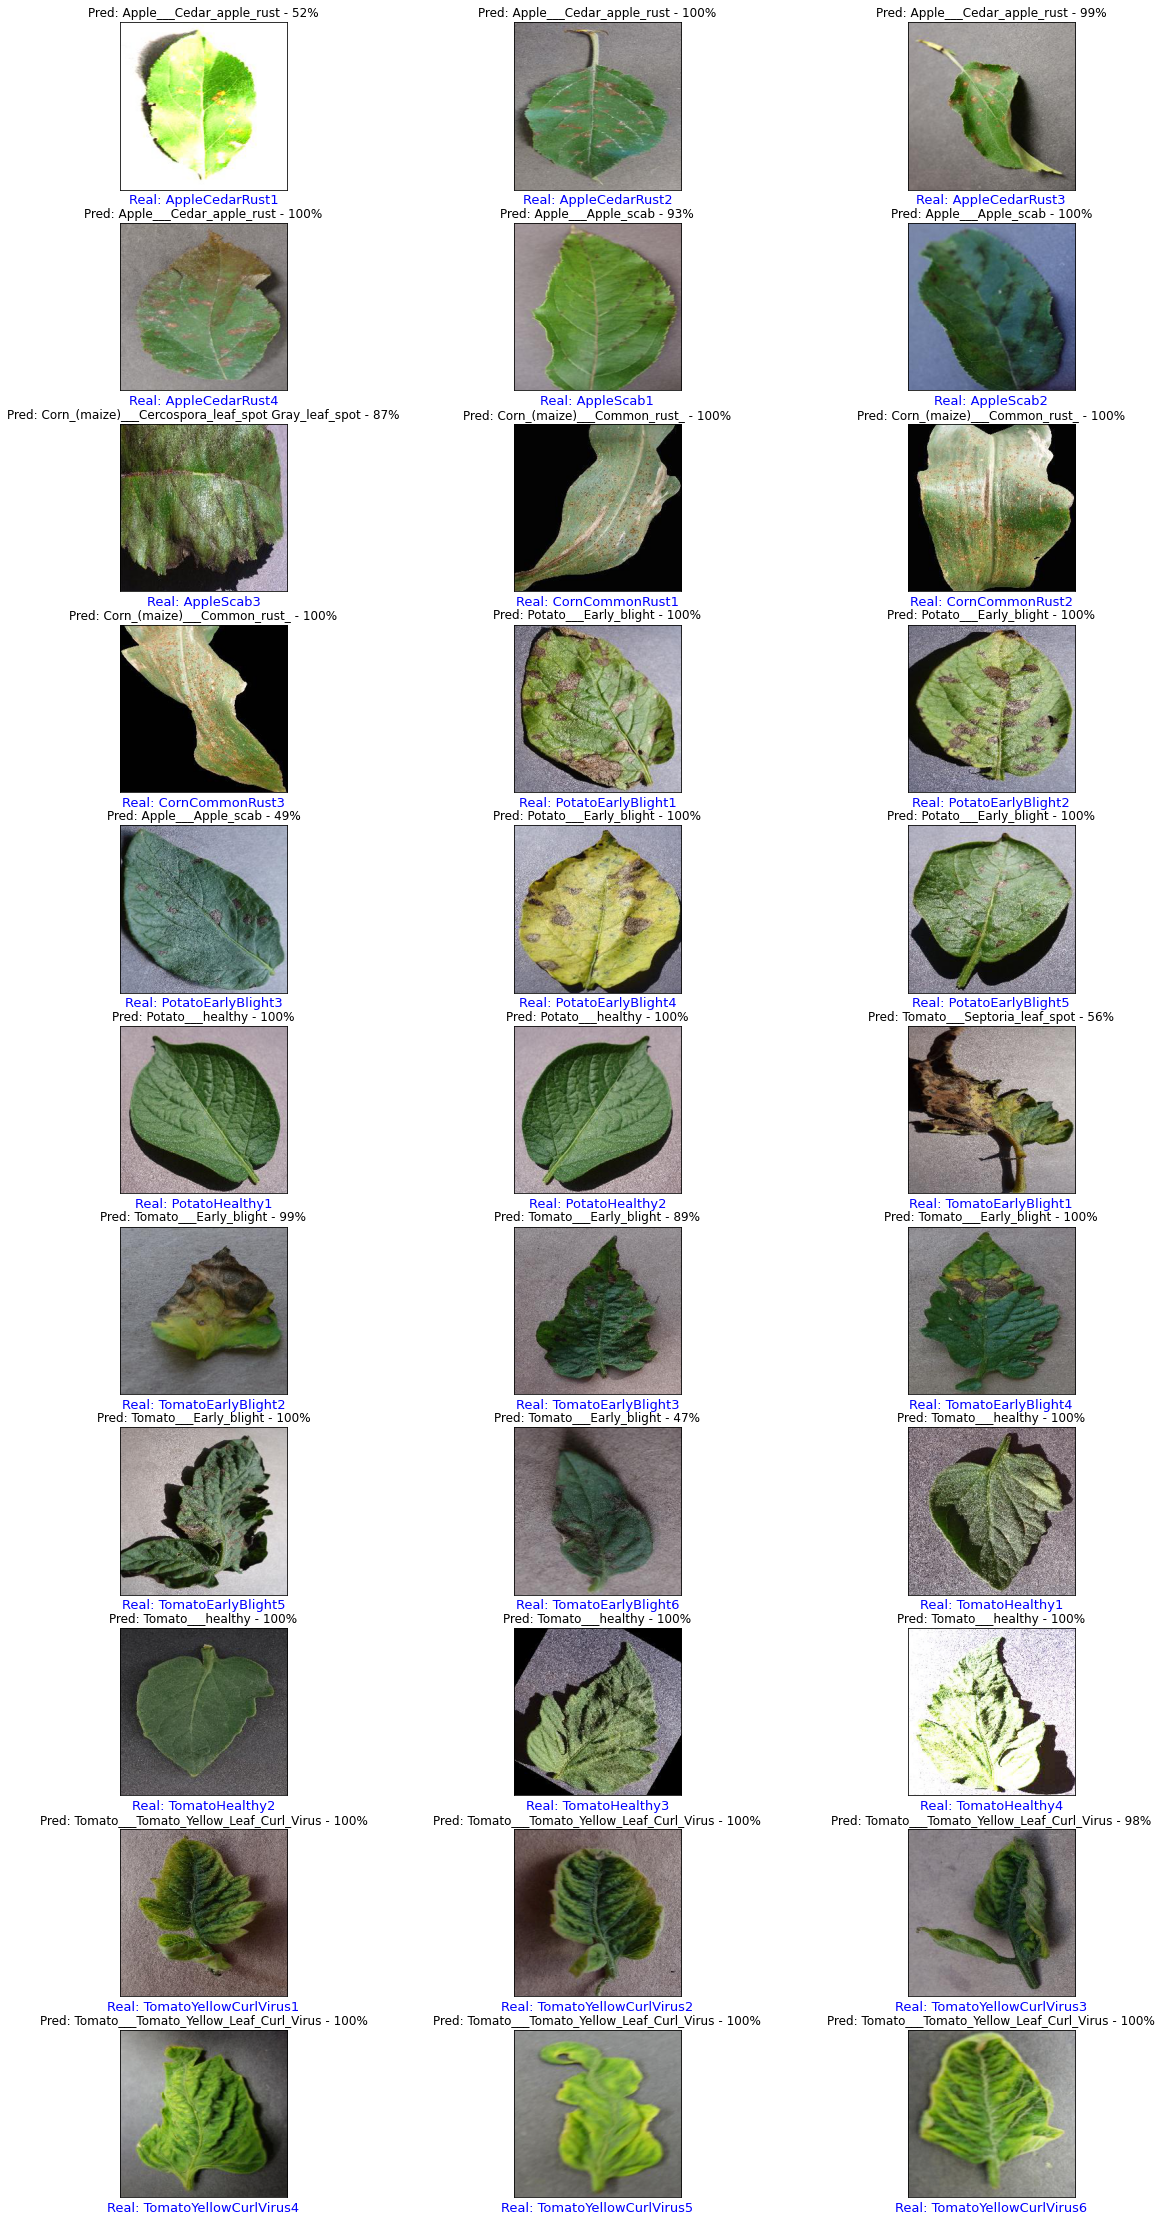

In [33]:
# Show Test Images
import matplotlib.image as mpimg

images_test = []
for img_path in df_test['Path']:
    images_test.append(mpimg.imread(img_path))

plt.figure(figsize=(20,40))
for i, image in enumerate(images_test):
    plt.subplot(11,3,i+1)
    plt.imshow(image)
    plt.title('Pred: {} - {:2.0f}%'.format( get_pred_label(test_preds[i]), np.max(test_preds[i])*100))
    plt.xlabel(f'Real: {test_ids[i]}', fontsize=13, color='blue')
    plt.xticks([])
    plt.yticks([])

### Model Card

In [34]:
# utility function to retun imgaes in Base64
def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')


In [39]:
from model_card_toolkit import ModelCardToolkit
model_card_output_path = os.path.join(os.getcwd(), 'model_card_output')
mct = ModelCardToolkit(model_card_output_path)
model_card = mct.scaffold_assets()

### Plot Accuracy & Loss

In [74]:
# Model training history
import csv
from collections import defaultdict

history=defaultdict(list)
csvfile = open('data/history_full_0.973_20210221.csv')
reader= csv.DictReader(csvfile)
for l in reader:
    for k,v in l.items():
        history[k].append(float(v))

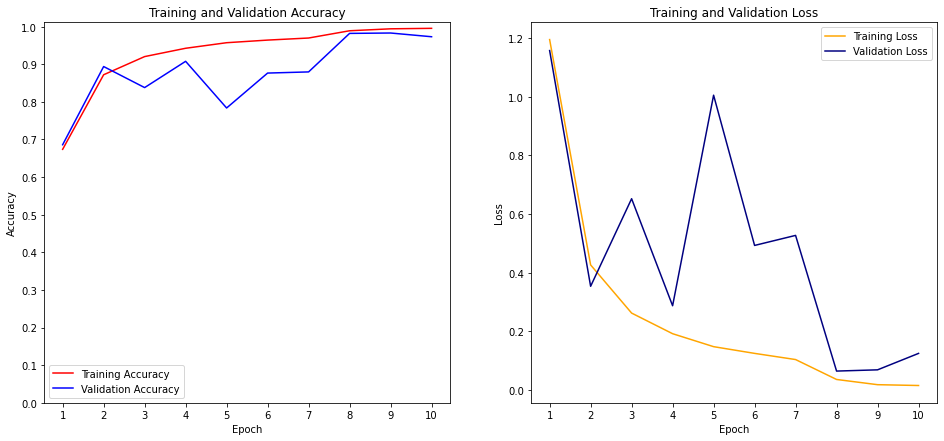

In [164]:
# Plot Accuracy & Loss
from io import BytesIO
import base64
plot_acc_and_loss(history)
acc_and_loss = plot_to_str()

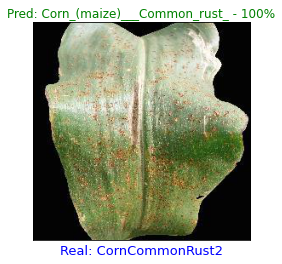

In [139]:
#get_pred_label(test_preds[8])
#np.max(test_preds[8])*100

plt.imshow(images_test[8])
plt.title('Pred: {} - {:2.0f}%'.format( get_pred_label(test_preds[8]), np.max(test_preds[8])*100),color='green')
plt.xlabel(f'Real: {test_ids[8]}', fontsize=13, color='blue')
plt.xticks([])
plt.yticks([])
corn_pred = plot_to_str()

In [113]:
# model Card

model_card.model_details.name = 'Crop Disease Classifier'
model_card.model_details.overview = (
    'This is a wide and deep Keras model which aims to classify crop disease '
    'In this Model Card, you can review quantitative '
    'components of the model’s performance and data, as well as information '
    'about the model’s intended uses, limitations, and ethical considerations.'
)
model_card.model_details.owners = [
  {'name': 'Murimisi DataScience Team', 'contact': 'data-science@murimisi.com'}
]

model_card.model_details.version = {'name': 'v0.1', 'date': '21/02/2021'}
model_card.model_details.references = [
    'https://www.tensorflow.org/tutorials/images/classification',
'https://www.frontiersin.org/articles/10.3389/fpls.2020.600854/full',
]
model_card.model_details.citation = 'https://github.com/muchemwal/.....'

In [243]:
model_card.considerations.use_cases = [
    'This dataset that this model was trained on was originally created to '
    'support a machine learning based mobile for farmers to predict crop diseases '
    'using a TF ML algorithm.'
]
model_card.considerations.users = [
    'Farmers', 'ML Researchers'
]

model_card.model_parameters.input_format = ('Photo(s)')
model_card.model_parameters.output_format = ('For each classification: classification, and % confidence')

model_card.model_parameters.model_architecture = ('Mobilenet CNN ........')

model_card.model_parameters.data.train.graphics.description = (
f'{len(X_train)} train images with {len(X_val)} validation images')

model_card.model_parameters.data.train.graphics.collection = [
{'image': acc_and_loss },
]

model_card.model_parameters.data.train.graphics.description = (
    'This graph displays the Training and Validation Accuracy for the number of epochs')

model_card.model_parameters.data.eval.graphics.collection = [
    {'name': 'Model Results', 'image': corn_pred},
  ]

model_card.model_parameters.data.eval.graphics.description = (
    'This graph displays a sample model prediction on a validation dataset with the prediction confidence. ')

model_card.considerations.limitations = [
    'Image Size:  Depending on image resolution, leaves that are distant from the camera (a pupillary distance of < 10px)'
    'might not be detected. Not designed for estimating the count of a leaves.'
    'Leaves greater than 90% of image height or width might not be detected. ',
    'Image Orientation: Leaves that are positioned away from the camera (pan > 90°, roll > 45°, or tilt > 45°)'
    ' might not be detected. ',
    'Lighting: Poorly illuminated/blured leaves might not be detected. ',
]
model_card.considerations.ethical_considerations = [{
    'name':
        'While distinguishing between crop disease for {} is generally agreed to be '
        'a benign application of machine learning, harmful results can occur '
        'when the model attempts to classify images that don’t contain {} ',
    'mitigation_strategy':
        'Avoid application on non {} images.'
}]

model_card.quantitative_analysis.performance_metrics = [
  {'type': 'accuracy', 'value': 0.99},
  {'type': 'accuracy', 'value': 0.98, 'slice':'Corn leaf blight'},
  {'type': 'accuracy', 'value': 0.99, 'slice':'Corn Rust'},
  {'type': 'accuracy', 'value': 0.1, 'slice':'Corn healthy'},
  {'type': 'accuracy', 'value': 0.1, 'slice':'Gray Leaf Spot'},
]

In [244]:
mct.update_model_card_json(model_card)

In [245]:
html = mct.export_format()
display.display(display.HTML(html))

In [ ]:
# Generate a model card document in Markdown
md_path = os.path.join(model_card_output_path, 'template/md/default_template.md.jinja')
md_doc = mct.export_format(md_path, 'crops_model_card.md')
 
# Display the model card document in Markdown
display.display(display.Markdown(md_doc))